In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Define constants
epochs = 200
batch_size = 64
lr = 0.0002
nworkers = 8
latent_dim = 100
sample_interval = 400
img_shape = (1, 28, 28)
adversarial_loss = torch.nn.BCELoss()
device = 'cuda'
valid = torch.ones(batch_size, 1, device=device)
fake = torch.zeros(batch_size, 1, device=device)


In [3]:
# Configure data loader
os.makedirs('./data/mnist', exist_ok=True)
transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])

dataset = datasets.MNIST('./data/mnist', train=True, download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [4]:
class Generator1(nn.Module):
    def __init__(self):
        super(Generator1, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator1(nn.Module):
    def __init__(self):
        super(Discriminator1, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

class Generator2(nn.Module):
    def __init__(self):
        super(Generator2, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator2(nn.Module):
    def __init__(self):
        super(Discriminator2, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity    

In [5]:
class GAN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.discriminator = Discriminator1().to(device)
        self.generator = Generator1().to(device)

    def forward(self, real_imgs):
        # Generator Forward
        z = torch.Tensor(np.random.normal(0, 1, (real_imgs.shape[0], latent_dim))).to(device)
        self.gen_img = self.generator(z)
        self.disc_gen = self.discriminator(self.gen_img)
        # This clears the function graph built up for the discriminator
        self.discriminator.zero_grad()

        # Discriminator Forward
        self.disc_gen_det = self.discriminator(self.gen_img.detach())
        self.disc_real = self.discriminator(real_imgs)
        
        return self.gen_img, self.disc_gen, self.disc_gen_det, self.disc_real

class GAN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.discriminator = Discriminator2().to(device)
        self.generator = Generator2().to(device)

    def forward(self, real_imgs):
        # Generator Forward
        z = torch.Tensor(np.random.normal(0, 1, (real_imgs.shape[0], latent_dim))).to(device)
        self.gen_img = self.generator(z)
        self.disc_gen = self.discriminator(self.gen_img)
        # This clears the function graph built up for the discriminator
        self.discriminator.zero_grad()

        # Discriminator Forward
        self.disc_gen_det = self.discriminator(self.gen_img.detach())
        self.disc_real = self.discriminator(real_imgs)
        
        return self.gen_img, self.disc_gen, self.disc_gen_det, self.disc_real

class GAN3(nn.Module):
    def __init__(self, disc_epoch, gen_epoch):
        super().__init__()
        gan1 = torch.load("gan1/models/gan%d.pt" %gen_epoch)
        gan2 = torch.load("gan2/models/gan%d.pt" %disc_epoch)
        self.generator = gan1.generator.to(device)
        self.discriminator = gan2.discriminator.to(device)

    def forward(self, real_imgs):
        # Generator Forward
        z = torch.Tensor(np.random.normal(0, 1, (real_imgs.shape[0], latent_dim))).to(device)
        self.gen_img = self.generator(z)
        self.disc_gen = self.discriminator(self.gen_img)
        # This clears the function graph built up for the discriminator
        self.discriminator.zero_grad()

        # Discriminator Forward
        self.disc_gen_det = self.discriminator(self.gen_img.detach())
        self.disc_real = self.discriminator(real_imgs)
        
        return self.gen_img, self.disc_gen, self.disc_gen_det, self.disc_real    

In [6]:
def run_gan(loader, gan, optimizer_g, optimizer_d, epoch, gan_number):
    for (img, _) in loader:
        img = img.to(device)
        gen_img, disc_gen, disc_gen_det, disc_real = gan(img)
        optimizer_g.zero_grad()
        fake_loss = adversarial_loss(disc_gen_det, fake)
        real_loss = adversarial_loss(disc_real, valid)
        g_loss = adversarial_loss(disc_gen, valid)
        g_loss.backward()
        optimizer_g.step()
        
        optimizer_d.zero_grad()
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_d.step()
#     print ("[D loss: %f] [G loss: %f]" % (d_loss.item(), g_loss.item()))
    if epoch % 10 == 0 :
        torch.cuda.empty_cache()
        print ("[D loss: %f] [G loss: %f]" % (d_loss.item(), g_loss.item()))
        model_file = "gan%d/models/gan%d.pt" %(gan_number,epoch)
        img_file = "gan%d/images/%d.png" %(gan_number,epoch)
        torch.save(gan, model_file)
        save_image(gen_img.data[:25], img_file, nrow=5, normalize=True)    

In [ ]:
gan1 = GAN1()
optimizer_g = torch.optim.Adam(gan1.generator.parameters(), lr=lr)
optimizer_d = torch.optim.Adam(gan1.discriminator.parameters(), lr=lr)

for i in range(100):
    run_gan(dataloader, gan1, optimizer_g, optimizer_d, i, 1)

In [ ]:
gan2 = GAN2()
optimizer_g = torch.optim.Adam(gan2.generator.parameters(), lr=lr)
optimizer_d = torch.optim.Adam(gan2.discriminator.parameters(), lr=lr)

for i in range(100):
    run_gan(dataloader, gan2, optimizer_g, optimizer_d, i, 2)

In [7]:
def eval_gan(loader, gan):
    g_losses = 0
    d_losses = 0
    for (img, _) in loader:
        img = img.to(device)
        gen_img, disc_gen, disc_gen_det, disc_real = gan(img)
        fake_loss = adversarial_loss(disc_gen_det, fake)
        real_loss = adversarial_loss(disc_real, valid)
        g_loss = adversarial_loss(disc_gen, valid)
        d_loss = (real_loss + fake_loss) / 2
        g_losses += g_loss.item()
        d_losses += d_loss.item()
#         torch.cuda.empty_cache()
    return g_losses, d_losses

In [11]:
g_losses = []
d_losses = []
for i in range(0, 100, 10):
    gan3 = GAN3(disc_epoch=i, gen_epoch=90)
    g_loss, d_loss = eval_gan(dataloader, gan3)
    g_losses.append(g_loss)
    d_losses.append(d_loss)

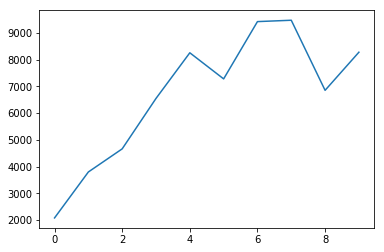

In [12]:
plt.plot(d_losses)

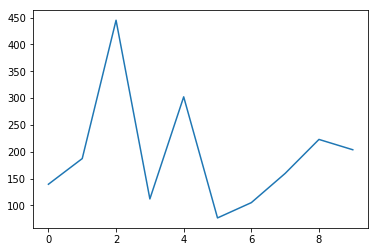

In [13]:
plt.plot(g_losses)

In [ ]:
d_losses

In [ ]:
g_losses

In [8]:
g_losses = []
d_losses = []
for i in range(0, 100, 10):
    gan3 = GAN3(disc_epoch=90, gen_epoch=i)
    g_loss, d_loss = eval_gan(dataloader, gan3)
    g_losses.append(g_loss)
    d_losses.append(d_loss)

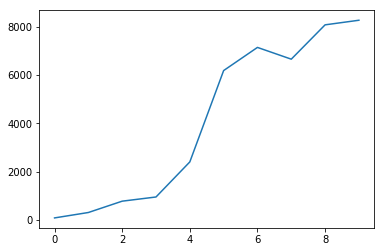

In [9]:
plt.plot(d_losses)

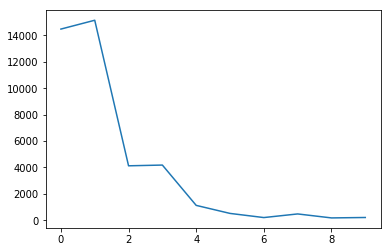

In [10]:
plt.plot(g_losses)